## Dash Board

Fill in all its functions as we go

1. Speaker Diarization 
2. speaker time share 
3. Transcript - save to file, organised by speaker, statistics 
4. Words per Minute - line plot, average WPM 
5. Emotion Tagging from Transcription - per segment, per speaker, overall, emotions over time, dominant emotion so far.

## Speaker Diarization - Who Said What

---

### What is Speaker Diarization?

**Diarization** = answering the question **"who spoke when?"**

It's like adding subtitles that say:
- `[00:00 - 00:15] SPEAKER_00: ...`
- `[00:15 - 00:32] SPEAKER_01: ...`

---

### Why Do We Need This?

For bias detection, we need to know:
- **Who is speaking** at any given moment
- **When they started** and stopped talking
- **How many speakers** are in the conversation
- **Which segments belong to which person**

Without diarization, we'd just have raw text with no idea who said what!

---

### How Does It Work?

**Step 1: Audio Analysis**
- The model analyzes voice characteristics (pitch, tone, frequency)
- Identifies unique "voice prints" for each person

**Step 2: Clustering**
- Groups similar voice segments together
- Assigns each group a speaker label (SPEAKER_00, SPEAKER_01, etc.)

**Step 3: Timestamps**
- Marks exactly when each speaker starts and stops talking

---

### Technology We're Using

**pyannote.audio 3.1** 
- State-of-the-art speaker diarization
- Developed by French research team (CNRS)
- Pre-trained on thousands of hours of speech
- Hosted on Hugging Face (requires free API token)

---

### What We'll Get

After diarization, we'll have a **DataFrame** with:

| start | end   | speaker     | duration |
|-------|-------|-------------|----------|
| 0.0   | 5.2   | SPEAKER_00  | 5.2      |
| 5.2   | 12.8  | SPEAKER_01  | 7.6      |
| 12.8  | 18.3  | SPEAKER_00  | 5.5      |

Each row = one speaking turn!

---


In [2]:
# Install all required packages
# Run this cell once

!pip install whisperx pyannote.audio librosa speechbrain torchaudio pandas matplotlib seaborn python-dotenv soundfile


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import all required libraries

# Core speech & audio libraries
import whisperx                          # Speech-to-text with speaker alignment
from pyannote.audio import Pipeline      # Speaker diarization (who spoke when)
import librosa                           # Audio loading & analysis
import librosa.display                   # Audio visualization (waveforms, spectrograms)
from speechbrain.pretrained import EncoderClassifier  # Emotion or speaker classification

# Deep learning & data handling
import torch                             # GPU acceleration (used by WhisperX / PyAnnote)
import pandas as pd                      # Dataframes for diarization/emotion results
import numpy as np                       # Numerical operations & signal processing

# Visualization
import matplotlib.pyplot as plt           # Plotting (timelines, charts, etc.)
import seaborn as sns                     # Prettier, themed plots

# Utilities & file handling
import os                                # File paths & environment management
import re                                # Regex for text cleaning or parsing
import tempfile                          # Temporary files for audio chunks
import soundfile as sf                   # Read/write WAV or FLAC audio files
from dotenv import load_dotenv           # Load API tokens / config from .env
from datetime import datetime            # For timestamps & logging


# Set plotting style
sns.set_style("whitegrid")                # Clean white background with grid
plt.rcParams['figure.dpi'] = 100          # Higher resolution plots

# Load environment variables
load_dotenv()                             # Load from .env file if present
HF_TOKEN = os.getenv("HF_TOKEN")          # Hugging Face API token for PyAnnote

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

print("=" * 70)
print("SPEAKSENSE - MEDIA BIAS DETECTION DASHBOARD")
print("=" * 70)
print(f"\nAll libraries imported")
print(f"Device: {device.upper()}")                                     # Log device being used
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")    # Log current time                                             
print("\n" + "=" * 70)

c:\Users\norak\SpeakSense\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()
c:\Users\norak\SpeakSense\venv\Lib\site-packages\speechbrain\utils\torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring 

SPEAKSENSE - MEDIA BIAS DETECTION DASHBOARD

All libraries imported
Device: CPU
Timestamp: 2025-11-23 20:16:00



Loading: ../data/US_DebateAudio.wav

Audio loaded successfully
  Sample rate: 44100 Hz
  Duration: 565.78s (9.43 min)
  Shape: (24950784,)


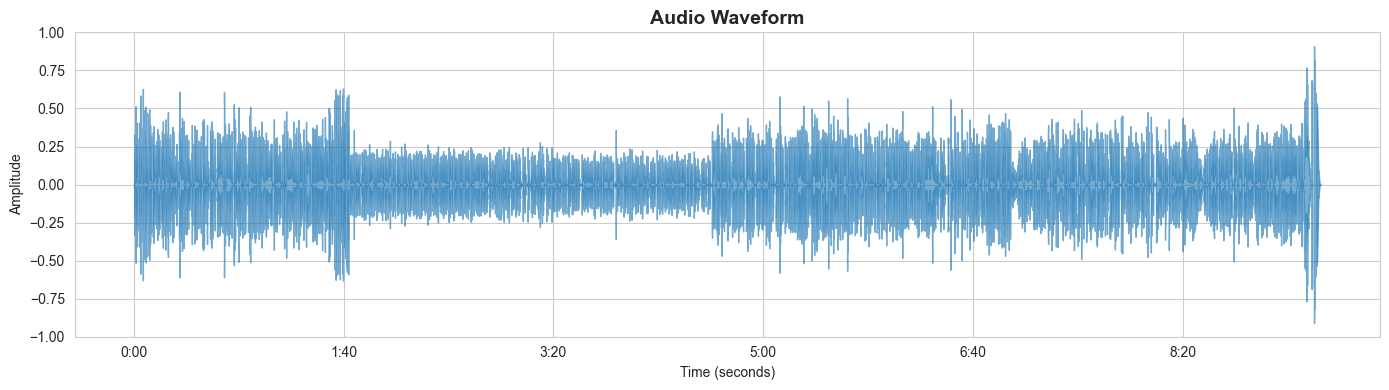

In [4]:
# Audio file path
audio_file = "../data/US_DebateAudio.wav"

print(f"Loading: {audio_file}")

# Load audio with librosa
audio, sample_rate = librosa.load(audio_file, sr=None)
duration = len(audio) / sample_rate                     # Calculate total duration in seconds


print(f"\nAudio loaded successfully")
print(f"  Sample rate: {sample_rate} Hz")
print(f"  Duration: {duration:.2f}s ({duration/60:.2f} min)")
print(f"  Shape: {audio.shape}")

# Quick visualization - Plot waveform

plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=sample_rate, alpha=0.6, color='#1f77b4')
plt.title('Audio Waveform', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [5]:
print("=" * 70)
print("SPEAKER DIARIZATION")
print("=" * 70)

# Load the pre-trained diarization model from Hugging Face
print("\n[1/2] Loading diarization model...")
diarize_model = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=HF_TOKEN
)

# Run the diarization pipeline on the audio file
print("[2/2] Running speaker diarization...")
diarize_segments = diarize_model(audio_file)

# Convert to DataFrame
diarize_list = []
for turn, _, speaker in diarize_segments.itertracks(yield_label=True):
    diarize_list.append({
        'start': turn.start,
        'end': turn.end,
        'speaker': speaker,
        'duration': turn.end - turn.start
    })
diarize_df = pd.DataFrame(diarize_list)

# Summary statistics
num_speakers = len(diarize_df['speaker'].unique())
print(f"\nDiarization complete!")
print(f"  Speakers identified: {num_speakers}")
print(f"  Total segments: {len(diarize_df)}")
print(f"\nFirst few segments:")
print(diarize_df.head(10))

SPEAKER DIARIZATION

[1/2] Loading diarization model...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()


[2/2] Running speaker diarization...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\c


Diarization complete!
  Speakers identified: 3
  Total segments: 54

First few segments:
        start         end     speaker   duration
0    0.030969   15.994719  SPEAKER_00  15.963750
1   16.095969   28.380969  SPEAKER_02  12.285000
2   28.515969   38.910969  SPEAKER_02  10.395000
3   39.366594   53.929719  SPEAKER_02  14.563125
4   54.081594   62.350344  SPEAKER_02   8.268750
5   62.333469   66.029094  SPEAKER_00   3.695625
6   66.501594   70.112844  SPEAKER_00   3.611250
7   70.298469  168.966594  SPEAKER_00  98.668125
8  169.084719  179.665344  SPEAKER_00  10.580625
9  179.732844  184.491594  SPEAKER_02   4.758750


In [6]:
print("=" * 70)
print("TRANSCRIPTION & ALIGNMENT")
print("=" * 70)

# Load WhisperX model (for speech-to-text)
# "base" is a small, efficient model
print("\n[1/3] Loading WhisperX model...")
model = whisperx.load_model("base", device=device, compute_type="int8" if device=="cpu" else "float16")

# Transcribe the full audio into text segments
print("[2/3] Transcribing audio...")
result = model.transcribe(audio_file)

# Align transcription with word-level timestamps for accuracy
# Adds start/end times to each word in the transcript
print("[3/3] Aligning to word-level timestamps...")
model_a, metadata = whisperx.load_align_model(language_code="en", device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio_file, device=device)

print("\nTranscription complete!")
print(f"  Segments: {len(result['segments'])}")
print(f"\nFirst segment preview:")
print(f"  {result['segments'][0].get('text', '')[:100]}...")

TRANSCRIPTION & ALIGNMENT

[1/3] Loading WhisperX model...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\ctranslate2\__init__.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


2025-11-23 20:26:00 - whisperx.asr - INFO - No language specified, language will be detected for each audio file (increases inference time)
2025-11-23 20:26:00 - whisperx.vads.pyannote - INFO - Performing voice activity detection using Pyannote...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\norak\SpeakSense\venv\Lib\site-packages\whisperx\assets\pytorch_model.bin`
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()


Model was trained with pyannote.audio 0.0.1, yours is 3.4.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.8.0+cpu. Bad things might happen unless you revert torch to 1.x.
[2/3] Transcribing audio...
2025-11-23 20:26:30 - whisperx.asr - INFO - Detected language: en (0.99) in first 30s of audio
[3/3] Aligning to word-level timestamps...

Transcription complete!
  Segments: 112

First segment preview:
   She doesn't have a plan....


In [7]:
print("\n" + "=" * 70)
print("ASSIGNING SPEAKERS TO TRANSCRIPT")
print("=" * 70)

# Combine diarization output with transcription
# Each word/segment now includes a speaker label (who said what)
result = whisperx.assign_word_speakers(diarize_df, result)

print("\nSpeakers assigned to transcript!")
print(f"  Total segments with speakers: {sum(1 for s in result['segments'] if 'speaker' in s)}")


ASSIGNING SPEAKERS TO TRANSCRIPT

Speakers assigned to transcript!
  Total segments with speakers: 112


SPEAKER TIME SHARE ANALYSIS

Speaking Time Breakdown:
  SPEAKER_00: 4.07 min (44.86%)
  SPEAKER_01: 0.12 min (1.32%)
  SPEAKER_02: 4.88 min (53.81%)


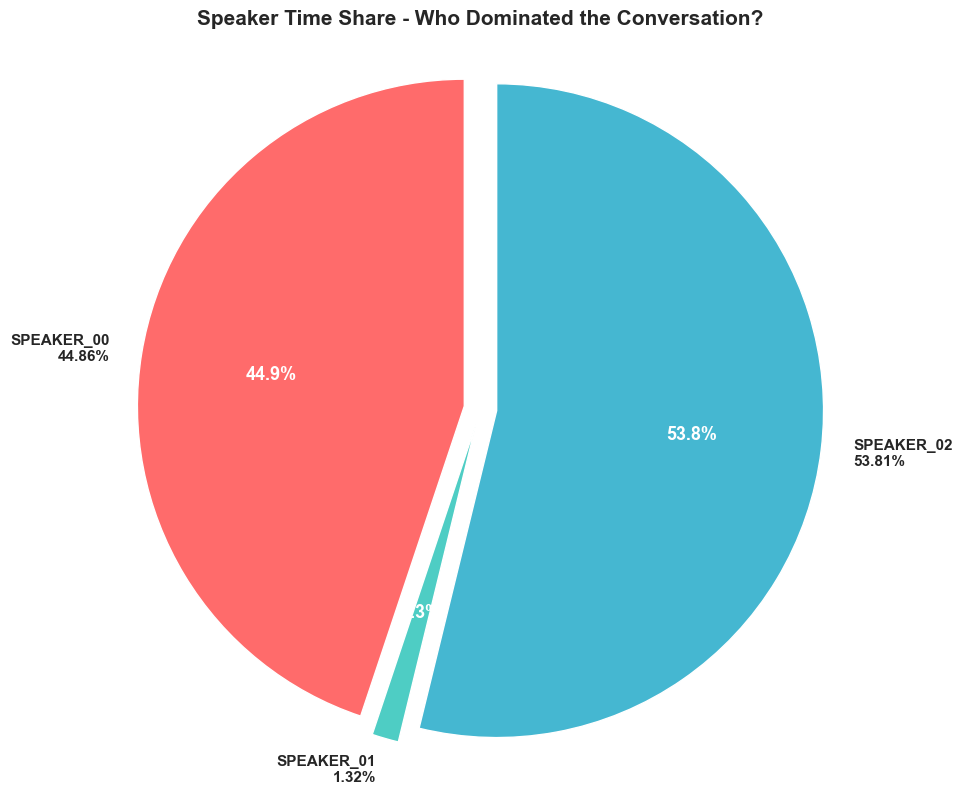

In [8]:
print("=" * 70)
print("SPEAKER TIME SHARE ANALYSIS")
print("=" * 70)

# Calculate total speaking time per speaker
speaker_time = diarize_df.groupby('speaker')['duration'].sum()
total_time = speaker_time.sum()
speaker_percentages = (speaker_time / total_time * 100).round(2)

# Print statistics
print("\nSpeaking Time Breakdown:")
for speaker, time in speaker_time.items():
    percentage = speaker_percentages[speaker]
    minutes = time / 60
    print(f"  {speaker}: {minutes:.2f} min ({percentage}%)")

# Create pie chart
plt.figure(figsize=(10, 8))
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffd93d', '#95e1d3']
explode = [0.05] * len(speaker_time)

wedges, texts, autotexts = plt.pie(
    speaker_time, 
    labels=[f"{s}\n{speaker_percentages[s]}%" for s in speaker_time.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(speaker_time)],
    explode=explode,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Make percentage text white and bold for readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)

plt.title('Speaker Time Share - Who Dominated the Conversation?', 
          fontsize=15, fontweight='bold', pad=20)
plt.axis('equal') # Keep pie chart circular
plt.tight_layout()
plt.show()

## Full Transcript with Speaker Labels

Now let's display the complete transcript in a readable format with:
- Speaker labels for each segment
- Timestamps showing when they spoke
- Clean formatting for easy reading

This is useful for:
- **Manual review** - Read what was actually said
- **Quote extraction** - Find important statements
- **Context analysis** - Understand the conversation flow
- **Report generation** - Export for your thesis

In [9]:
# ============================================================
# FORMATTED TRANSCRIPT WITH SPEAKER LABELS
# ============================================================

print("=" * 70)
print("FULL TRANSCRIPT - US DEBATE")
print("=" * 70)
print("\n")

# ------------------------------------------------------------
# Display each segment with speaker and timestamp
# ------------------------------------------------------------

for idx, segment in enumerate(result['segments'], 1):
    # Extract segment information
    speaker = segment.get('speaker', 'UNKNOWN')
    start = segment['start']
    end = segment['end']
    text = segment.get('text', '').strip()
    
    # Format timestamp as MM:SS
    start_min = int(start // 60)
    start_sec = int(start % 60)
    end_min = int(end // 60)
    end_sec = int(end % 60)
    
    # Print formatted segment
    print(f"[{idx:03d}] {speaker} | [{start_min:02d}:{start_sec:02d} → {end_min:02d}:{end_sec:02d}]")
    print(f"      {text}")
    print()  # Blank line between segments

print("=" * 70)
print(f"✓ Transcript complete: {len(result['segments'])} total segments")
print("=" * 70)

FULL TRANSCRIPT - US DEBATE


[001] SPEAKER_00 | [00:00 → 00:01]
      She doesn't have a plan.

[002] SPEAKER_00 | [00:02 → 00:12]
      She copied Biden's plan and it's like four sentences, like run spot run, four sentences that are just, oh, we'll try and lower taxes.

[003] SPEAKER_00 | [00:12 → 00:13]
      She doesn't have a plan.

[004] SPEAKER_00 | [00:13 → 00:14]
      Take a look at her plan.

[005] SPEAKER_00 | [00:14 → 00:16]
      She doesn't have a plan.

[006] SPEAKER_02 | [00:16 → 00:20]
      I believe in the ambition, the aspirations, the dreams of the American people.

[007] SPEAKER_02 | [00:21 → 00:26]
      And that is why I imagine and have actually a plan to build what I call an opportunity economy.

[008] SPEAKER_02 | [00:27 → 00:28]
      Because here's the thing.

[009] SPEAKER_02 | [00:28 → 00:32]
      We know that we have a shortage of homes in housing.

[010] SPEAKER_02 | [00:32 → 00:35]
      And the cost of housing is too expensive for too many people.



In [10]:
# ============================================================
# SAVE TRANSCRIPT TO TEXT FILE
# ============================================================

# Create output filename with timestamp
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f"../outputs/transcript_{timestamp}.txt"

# Ensure output directory exists
os.makedirs("../outputs", exist_ok=True)

print(f"Saving transcript to: {output_file}")

# Write transcript to file
with open(output_file, 'w', encoding='utf-8') as f:
    # Write header
    f.write("=" * 70 + "\n")
    f.write("FULL TRANSCRIPT - US DEBATE\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Audio file: {audio_file}\n")
    f.write(f"Duration: {duration:.2f}s ({duration/60:.2f} min)\n")
    f.write(f"Speakers: {num_speakers}\n")
    f.write(f"Segments: {len(result['segments'])}\n")
    f.write("=" * 70 + "\n\n")
    
    # Write each segment
    for idx, segment in enumerate(result['segments'], 1):
        speaker = segment.get('speaker', 'UNKNOWN')
        start = segment['start']
        end = segment['end']
        text = segment.get('text', '').strip()
        
        # Format timestamp
        start_min = int(start // 60)
        start_sec = int(start % 60)
        end_min = int(end // 60)
        end_sec = int(end % 60)
        
        # Write to file
        f.write(f"[{idx:03d}] {speaker} | [{start_min:02d}:{start_sec:02d} → {end_min:02d}:{end_sec:02d}]\n")
        f.write(f"      {text}\n\n")
    
    # Write footer
    f.write("=" * 70 + "\n")
    f.write(f"Transcript complete: {len(result['segments'])} total segments\n")
    f.write("=" * 70 + "\n")

print(f"Transcript saved successfully!")
print(f"File location: {output_file}")

Saving transcript to: ../outputs/transcript_20251123_202953.txt
Transcript saved successfully!
File location: ../outputs/transcript_20251123_202953.txt


In [11]:
# ============================================================
# TRANSCRIPT ORGANIZED BY SPEAKER
# ============================================================

print("=" * 70)
print("TRANSCRIPT BY SPEAKER")
print("=" * 70)

# Get unique speakers
speakers = sorted(diarize_df['speaker'].unique())

for speaker in speakers:
    print(f"\n{'=' * 70}")
    print(f"{speaker}")
    print(f"{'=' * 70}\n")
    
    # Get all segments for this speaker
    speaker_segments = [s for s in result['segments'] if s.get('speaker') == speaker]
    
    print(f"Total segments: {len(speaker_segments)}")
    print(f"Total speaking time: {speaker_time[speaker]:.2f}s ({speaker_time[speaker]/60:.2f} min)")
    print()
    
    # Display all their segments
    for idx, segment in enumerate(speaker_segments, 1):
        start = segment['start']
        end = segment['end']
        text = segment.get('text', '').strip()
        
        # Format timestamp
        start_min = int(start // 60)
        start_sec = int(start % 60)
        
        print(f"[{idx:03d}] [{start_min:02d}:{start_sec:02d}] {text}")
    
    print()

print("=" * 70)

TRANSCRIPT BY SPEAKER

SPEAKER_00

Total segments: 64
Total speaking time: 244.06s (4.07 min)

[001] [00:00] She doesn't have a plan.
[002] [00:02] She copied Biden's plan and it's like four sentences, like run spot run, four sentences that are just, oh, we'll try and lower taxes.
[003] [00:12] She doesn't have a plan.
[004] [00:13] Take a look at her plan.
[005] [00:14] She doesn't have a plan.
[006] [01:02] We're doing tariffs on other countries.
[007] [01:04] Other countries are going to finally after
[008] [01:06] 75 years pay us back for all that we've done for the world.
[009] [01:10] Look, we've had a terrible economy because inflation has, which is really known as a country mustard, breaks up countries.
[010] [01:18] We have inflation like very few people have ever seen before, probably the worst in our nation's history.
[011] [01:24] We were at 21 percent, but that's being generous because many things are 50, 60, 70, and 80 percent higher than they were just a few years ago.
[

In [12]:
# ============================================================
# TRANSCRIPT STATISTICS
# ============================================================

print("=" * 70)
print("TRANSCRIPT STATISTICS")
print("=" * 70)

# Calculate word counts
total_words = 0
speaker_word_counts = {}

for segment in result['segments']:
    speaker = segment.get('speaker', 'UNKNOWN')
    text = segment.get('text', '').strip()
    word_count = len(text.split())
    
    total_words += word_count
    
    if speaker not in speaker_word_counts:
        speaker_word_counts[speaker] = 0
    speaker_word_counts[speaker] += word_count

# Display statistics
print(f"\nOVERALL STATISTICS:")
print(f"  Total words spoken: {total_words:,}")
print(f"  Total segments: {len(result['segments'])}")
print(f"  Average words per segment: {total_words/len(result['segments']):.1f}")

print(f"\nPER-SPEAKER STATISTICS:")
for speaker in sorted(speaker_word_counts.keys()):
    word_count = speaker_word_counts[speaker]
    time_spoken = speaker_time[speaker]
    wpm = (word_count / time_spoken) * 60 if time_spoken > 0 else 0
    percentage = (word_count / total_words) * 100
    
    print(f"\n  {speaker}:")
    print(f"    Words spoken: {word_count:,} ({percentage:.1f}% of total)")
    print(f"    Speaking time: {time_spoken:.1f}s ({time_spoken/60:.2f} min)")
    print(f"    Average WPM: {wpm:.1f}")

print("\n" + "=" * 70)

TRANSCRIPT STATISTICS

OVERALL STATISTICS:
  Total words spoken: 1,514
  Total segments: 112
  Average words per segment: 13.5

PER-SPEAKER STATISTICS:

  SPEAKER_00:
    Words spoken: 725 (47.9% of total)
    Speaking time: 244.1s (4.07 min)
    Average WPM: 178.2

  SPEAKER_01:
    Words spoken: 13 (0.9% of total)
    Speaking time: 7.2s (0.12 min)
    Average WPM: 108.5

  SPEAKER_02:
    Words spoken: 776 (51.3% of total)
    Speaking time: 292.7s (4.88 min)
    Average WPM: 159.0



## Words Per Minute (WPM) Analysis

### What is WPM?

**Words Per Minute (WPM)** measures how fast someone is speaking at any given moment.

---

### How is WPM Calculated?

It's actually very simple! For each segment of speech:

**Formula:**
'''
WPM = ( Number of Words  /  Duration in Seconds ) × 60
'''

**Example:**
- Segment text: "I think this is a really important issue"
- Word count: 8 words
- Duration: 4 seconds
- **Calculation**: (8 words / 4 seconds) × 60 = **120 WPM**

---

### Why Does Speaking Speed Matter for Bias Detection?

**Fast speaking can indicate:**
 Aggression , Nervousness, Time pressure, Confidence 

**Slow speaking can indicate:**
Deliberation, Confidence, Hesitation, Complexity

---

### What Will Be Analyzed:

1. **Average WPM per speaker** - Who talks faster overall?
2. **WPM over time** - Does pace change during the debate?
3. **WPM spikes** - When do speakers speed up or slow down?
4. **Comparative analysis** - Speaking pattern differences

---

### Interpretation Guide:

| WPM Range | Interpretation |
|-----------|----------------|
| **< 100 WPM** | Very slow, deliberate, or hesitant |
| **100-130 WPM** | Normal conversational pace |
| **130-160 WPM** | Fast, confident speaking |
| **160-200 WPM** | Very fast, possibly aggressive or nervous |
| **> 200 WPM** | Extremely fast, potentially overwhelming |

**Average conversational English:** ~130-150 WPM  
**Professional presenters:** ~150-170 WPM 

In [13]:
# ============================================================
# WORDS PER MINUTE (WPM) CALCULATION
# ============================================================

print("=" * 70)
print("CALCULATING WORDS PER MINUTE (WPM)")
print("=" * 70)

# ------------------------------------------------------------
# Calculate WPM for each segment
# ------------------------------------------------------------

wpm_data = []

for segment in result['segments']:
    # Extract segment data
    speaker = segment.get('speaker', 'UNKNOWN')
    text = segment.get('text', '').strip()
    start = segment['start']
    end = segment['end']
    duration = end - start
    
    # Skip very short segments 
    if duration < 0.5:
        continue
    
    # Calculate word count and WPM
    word_count = len(text.split())
    wpm = (word_count / duration) * 60  # Convert to words per minute
    
    # Store results
    wpm_data.append({
        'speaker': speaker,
        'start': start,
        'end': end,
        'duration': duration,
        'words': word_count,
        'wpm': wpm,
        'text': text[:50]  # First 50 chars for reference
    })

# Convert to DataFrame for easier analysis
wpm_df = pd.DataFrame(wpm_data)

print(f"\n✓ Calculated WPM for {len(wpm_df)} segments")
print(f"\nFirst few WPM measurements:")
print(wpm_df[['speaker', 'start', 'wpm', 'words']].head(10))

# ------------------------------------------------------------
# Summary statistics per speaker
# ------------------------------------------------------------

print("\n" + "=" * 70)
print("WPM SUMMARY BY SPEAKER")
print("=" * 70)

for speaker in sorted(wpm_df['speaker'].unique()):
    speaker_wpm = wpm_df[wpm_df['speaker'] == speaker]['wpm']
    
    print(f"\n{speaker}:")
    print(f"  Average WPM: {speaker_wpm.mean():.1f}")
    print(f"  Median WPM:  {speaker_wpm.median():.1f}")
    print(f"  Min WPM:     {speaker_wpm.min():.1f}")
    print(f"  Max WPM:     {speaker_wpm.max():.1f}")
    print(f"  Std Dev:     {speaker_wpm.std():.1f}")

print("\n" + "=" * 70)

CALCULATING WORDS PER MINUTE (WPM)

✓ Calculated WPM for 110 segments

First few WPM measurements:
      speaker   start         wpm  words
0  SPEAKER_00   0.031  168.067227      5
1  SPEAKER_00   2.217  140.255187     24
2  SPEAKER_00  12.985  356.294537      5
3  SPEAKER_00  13.847  437.956204      6
4  SPEAKER_00  14.890  241.351569      5
5  SPEAKER_02  16.113  160.197166     13
6  SPEAKER_02  21.543  209.174312     19
7  SPEAKER_02  27.394  299.625468      4
8  SPEAKER_02  28.756  163.083766     11
9  SPEAKER_02  32.823  256.684492     12

WPM SUMMARY BY SPEAKER

SPEAKER_00:
  Average WPM: 209.1
  Median WPM:  206.7
  Min WPM:     112.7
  Max WPM:     438.0
  Std Dev:     59.9

SPEAKER_01:
  Average WPM: 182.4
  Median WPM:  182.4
  Min WPM:     146.9
  Max WPM:     217.9
  Std Dev:     50.2

SPEAKER_02:
  Average WPM: 173.6
  Median WPM:  167.1
  Min WPM:     104.2
  Max WPM:     299.6
  Std Dev:     46.0



CREATING WPM TIMELINE VISUALIZATION
WPM timeline plot created!


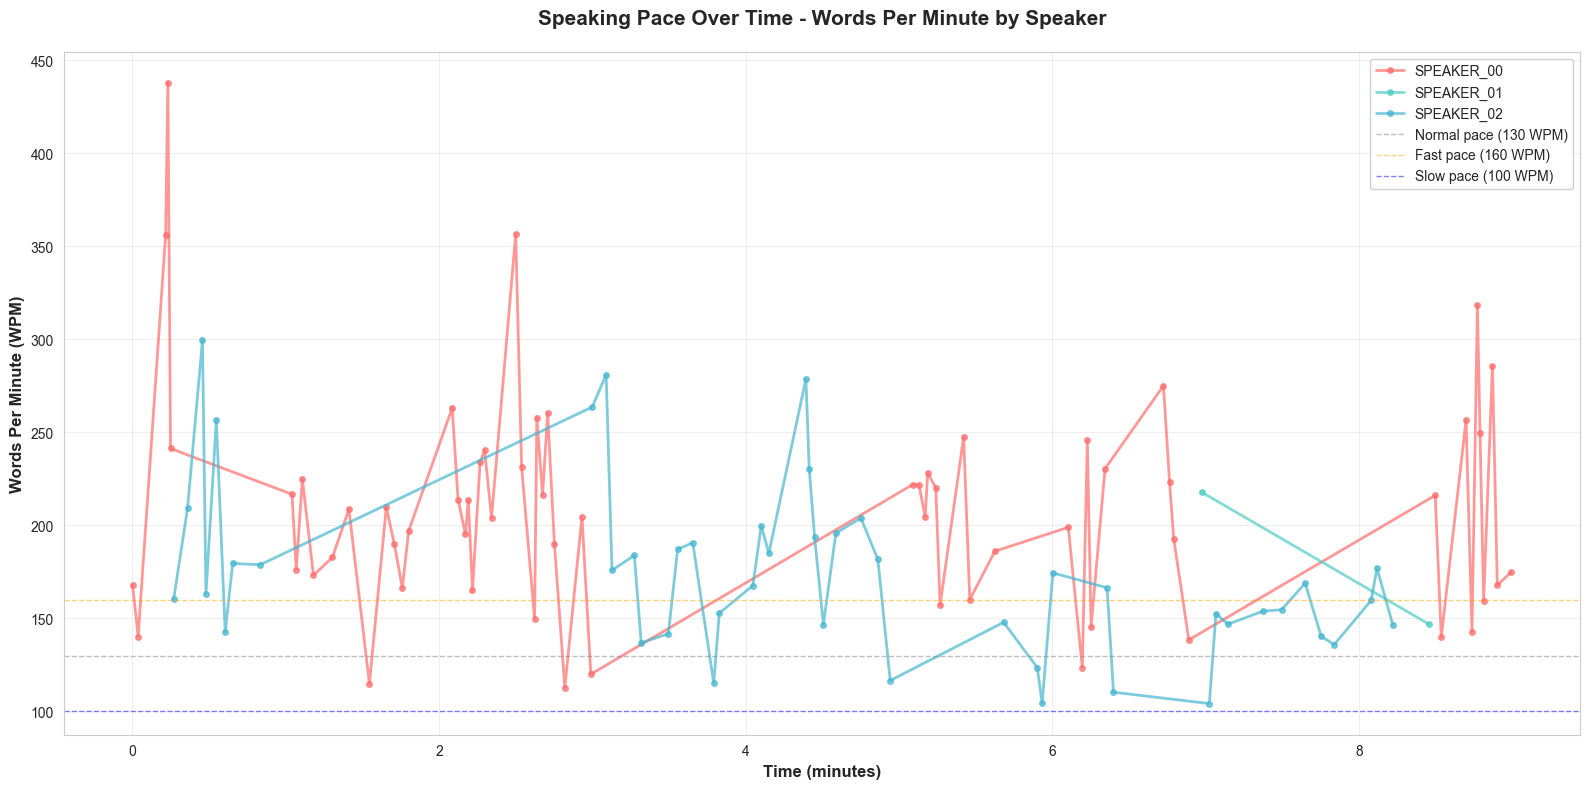

In [14]:
# ============================================================
# WPM LINE PLOT - SPEAKING PACE OVER TIME
# ============================================================

print("=" * 70)
print("CREATING WPM TIMELINE VISUALIZATION")
print("=" * 70)

# Get unique speakers
speakers = sorted(wpm_df['speaker'].unique())

# Define colors for each speaker
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffd93d', '#95e1d3']
speaker_colors = {speaker: colors[i % len(colors)] for i, speaker in enumerate(speakers)}

# ------------------------------------------------------------
# Create the line plot
# ------------------------------------------------------------

plt.figure(figsize=(16, 8))

# Plot WPM line for each speaker
for speaker in speakers:
    speaker_data = wpm_df[wpm_df['speaker'] == speaker]
    
    # Use segment start time as x-axis
    x = speaker_data['start'] / 60  # Convert to minutes
    y = speaker_data['wpm']
    
    # Plot line with markers
    plt.plot(x, y, 
             marker='o', 
             label=speaker, 
             color=speaker_colors[speaker],
             linewidth=2,
             markersize=4,
             alpha=0.7)

# ------------------------------------------------------------
# Add reference lines for speaking pace zones
# ------------------------------------------------------------

plt.axhline(y=130, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Normal pace (130 WPM)')
plt.axhline(y=160, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Fast pace (160 WPM)')
plt.axhline(y=100, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='Slow pace (100 WPM)')

# ------------------------------------------------------------
# Styling
# ------------------------------------------------------------

plt.xlabel('Time (minutes)', fontsize=12, fontweight='bold')
plt.ylabel('Words Per Minute (WPM)', fontsize=12, fontweight='bold')
plt.title('Speaking Pace Over Time - Words Per Minute by Speaker', 
          fontsize=15, fontweight='bold', pad=20)

plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

print("WPM timeline plot created!")
plt.show()


WPM TIMELINE (ZOOMED: 5:00 to 7:00)


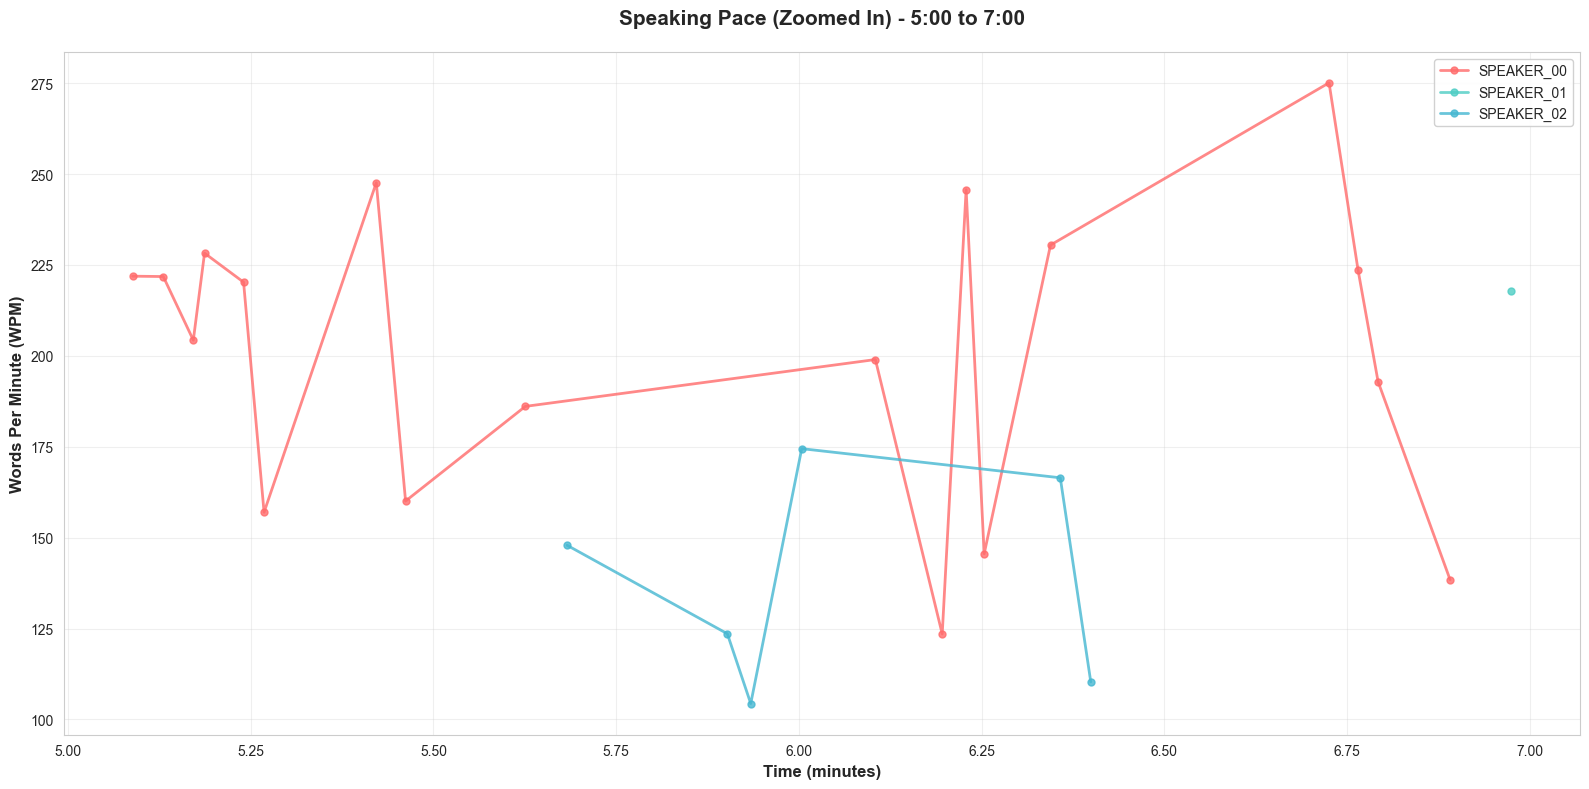

In [25]:
# ============================================================
# ZOOMED-IN WPM LINE PLOT - SELECTED TIME WINDOW
# ============================================================

# Set your desired zoom window (in seconds)
zoom_start = 300   # e.g. 5 minutes in
zoom_end = 420     # e.g. 7 minutes in

print("=" * 70)
print(f"WPM TIMELINE (ZOOMED: {zoom_start//60}:{zoom_start%60:02d} to {zoom_end//60}:{zoom_end%60:02d})")
print("=" * 70)

plt.figure(figsize=(16, 8))

for speaker in speakers:
    speaker_data = wpm_df[
        (wpm_df['speaker'] == speaker) &
        (wpm_df['start'] >= zoom_start) &
        (wpm_df['start'] <= zoom_end)
    ]
    x = speaker_data['start'] / 60  # minutes
    y = speaker_data['wpm']
    plt.plot(x, y,
             marker='o',
             label=speaker,
             color=speaker_colors[speaker],
             linewidth=2,
             markersize=5,
             alpha=0.8)

plt.xlabel('Time (minutes)', fontsize=12, fontweight='bold')
plt.ylabel('Words Per Minute (WPM)', fontsize=12, fontweight='bold')
plt.title(f'Speaking Pace (Zoomed In) - {zoom_start//60}:{zoom_start%60:02d} to {zoom_end//60}:{zoom_end%60:02d}', fontsize=15, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

AVERAGE WPM COMPARISON

Average WPM comparison chart created!


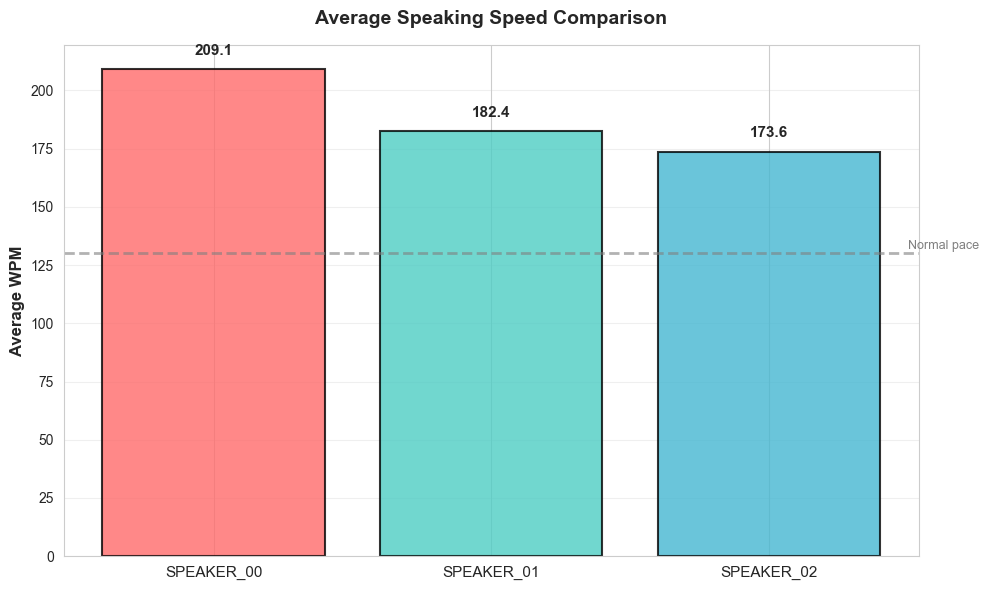


INTERPRETATION

SPEAKER_00: 209.1 WPM
  → Very fast - potentially overwhelming

SPEAKER_01: 182.4 WPM
  → Fast - confident or aggressive

SPEAKER_02: 173.6 WPM
  → Fast - confident or aggressive



In [15]:
# ============================================================
# AVERAGE WPM BAR CHART
# ============================================================

print("=" * 70)
print("AVERAGE WPM COMPARISON")
print("=" * 70)

# Calculate average WPM per speaker
avg_wpm = wpm_df.groupby('speaker')['wpm'].mean().sort_values(ascending=False)

# Create bar chart
plt.figure(figsize=(10, 6))

bars = plt.bar(range(len(avg_wpm)), 
               avg_wpm.values, 
               color=[speaker_colors[speaker] for speaker in avg_wpm.index],
               alpha=0.8,
               edgecolor='black',
               linewidth=1.5)

# Add value labels on bars
for i, (speaker, wpm) in enumerate(avg_wpm.items()):
    plt.text(i, wpm + 5, f'{wpm:.1f}', 
             ha='center', va='bottom', 
             fontweight='bold', fontsize=11)

# Styling
plt.xticks(range(len(avg_wpm)), avg_wpm.index, fontsize=11)
plt.ylabel('Average WPM', fontsize=12, fontweight='bold')
plt.title('Average Speaking Speed Comparison', fontsize=14, fontweight='bold', pad=15)

# Add reference line
plt.axhline(y=130, color='gray', linestyle='--', linewidth=2, alpha=0.6)
plt.text(len(avg_wpm)-0.5, 132, 'Normal pace', fontsize=9, color='gray')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

print("\nAverage WPM comparison chart created!")
plt.show()

# Print interpretation
print("\n" + "=" * 70)
print("INTERPRETATION")
print("=" * 70)

for speaker, wpm in avg_wpm.items():
    if wpm < 100:
        pace = "Very slow - deliberate or hesitant"
    elif wpm < 130:
        pace = "Slow - careful, measured"
    elif wpm < 160:
        pace = "Normal - conversational"
    elif wpm < 200:
        pace = "Fast - confident or aggressive"
    else:
        pace = "Very fast - potentially overwhelming"
    
    print(f"\n{speaker}: {wpm:.1f} WPM")
    print(f"  → {pace}")

print("\n" + "=" * 70)

## Words Spoken by Each Speaker

In [16]:
# ============================================================
# WORD COUNT PER SPEAKER (Simple Table)
# ============================================================

print("=" * 70)
print("WORD COUNT PER SPEAKER")
print("=" * 70)

# Calculate word count per speaker
word_count_per_speaker = {}

for segment in result['segments']:
    speaker = segment.get('speaker', 'UNKNOWN')
    text = segment.get('text', '').strip()
    count = len(text.split())
    word_count_per_speaker[speaker] = word_count_per_speaker.get(speaker, 0) + count

# Display results
for speaker, count in word_count_per_speaker.items():
    print(f"{speaker}: {count} words")

print("=" * 70)

WORD COUNT PER SPEAKER
SPEAKER_00: 725 words
SPEAKER_02: 776 words
SPEAKER_01: 13 words


## Emotion Detection Analysis

### What is Emotion Detection?

**Emotion detection** uses AI to identify the emotional tone of speech by analyzing the **words and language** used in the transcript.

---

### How Does It Work?

We use a **pre-trained transformer model** (DistilBERT) that has been fine-tuned on thousands of emotional texts to recognize patterns:

**The model detects 6 emotions:**
Anger, Joy, Sadness, Fear, Surprise, Neutral
---

### How is it Calculated?

For each transcript segment:

1. **Text goes into the model**: "I strongly disagree with that policy!"
2. **Model analyzes word patterns**: 
   - "strongly" = intensity modifier
   - "disagree" = negative stance
   - "!" = emphasis
3. **Returns emotion probabilities**:
   ```
   anger: 0.87 (87% confident)
   neutral: 0.08
   sadness: 0.03
   joy: 0.01
   fear: 0.01
   ```
4. **Top emotion is assigned**: **Anger** (0.87 confidence)

---

### What Will Be Analysed:

1. **Overall emotion distribution** - What emotions dominate?
2. **Per-speaker emotion profiles** - Who is more emotional?
3. **Emotion timeline** - When do emotions spike?
4. **Dominant emotions** - Which emotions are most common per speaker?

---

### Technology:

**Model:** `distilbert-base-uncased-emotion`  
**Training data:** Thousands of labeled emotional texts  
**Method:** Text-based (analyzes transcript, not audio tone)  
**Speed:** Fast - processes text instantly  

---

In [17]:
# Install transformers library for emotion detection
# Run this cell once if not already installed

!pip install transformers torch


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# ============================================================
# LOAD EMOTION DETECTION MODEL
# ============================================================

print("=" * 70)
print("LOADING EMOTION DETECTION MODEL")
print("=" * 70)

from transformers import pipeline

# Load pre-trained emotion detection model
print("\nLoading DistilBERT emotion classifier...")
emotion_detector = pipeline(
    "text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion",
    top_k=None,  # Return scores for all emotions
    device=0 if device == "cuda" else -1  # Use GPU if available
)

print("Emotion detection model loaded successfully!")
print("\nModel can detect 6 emotions:")
print("Anger")
print("Joy")
print("Sadness")
print("Fear")
print("Surprise")
print("Neutral")

print("\n" + "=" * 70)

LOADING EMOTION DETECTION MODEL

Loading DistilBERT emotion classifier...


Device set to use cpu


Emotion detection model loaded successfully!

Model can detect 6 emotions:
Anger
Joy
Sadness
Fear
Surprise
Neutral



In [19]:
# ============================================================
# EMOTION DETECTION PER SEGMENT
# ============================================================

print("=" * 70)
print("ANALYZING EMOTIONS IN TRANSCRIPT")
print("=" * 70)

emotion_data = []

print("\nProcessing segments...")
for idx, segment in enumerate(result['segments'], 1):
    speaker = segment.get('speaker', 'UNKNOWN')
    text = segment.get('text', '').strip()
    start = segment['start']
    
    # Skip empty segments
    if not text or len(text) < 5:
        continue
    
    # Detect emotion
    try:
        emotion_results = emotion_detector(text)[0]  # Returns list of all emotions with scores
        
        # Get top emotion
        top_emotion = max(emotion_results, key=lambda x: x['score'])
        
        # Store results
        emotion_data.append({
            'segment_id': idx,
            'speaker': speaker,
            'start': start,
            'text': text,
            'emotion': top_emotion['label'],
            'confidence': top_emotion['score'],
            'all_scores': {e['label']: e['score'] for e in emotion_results}
        })
        
        # Progress indicator
        if idx % 20 == 0:
            print(f"  Processed {idx}/{len(result['segments'])} segments...")
            
    except Exception as e:
        print(f"Error processing segment {idx}: {e}")
        continue

# Convert to DataFrame
emotion_df = pd.DataFrame(emotion_data)

print(f"\nEmotion analysis complete!")
print(f"  Total segments analyzed: {len(emotion_df)}")
print(f"\nFirst few emotion predictions:")
print(emotion_df[['speaker', 'emotion', 'confidence', 'text']].head(10))

print("\n" + "=" * 70)

ANALYZING EMOTIONS IN TRANSCRIPT

Processing segments...
  Processed 20/112 segments...
  Processed 40/112 segments...
  Processed 60/112 segments...
  Processed 80/112 segments...
  Processed 100/112 segments...

Emotion analysis complete!
  Total segments analyzed: 112

First few emotion predictions:
      speaker  emotion  confidence  \
0  SPEAKER_00    anger    0.928169   
1  SPEAKER_00      joy    0.852566   
2  SPEAKER_00    anger    0.928169   
3  SPEAKER_00    anger    0.488353   
4  SPEAKER_00    anger    0.928169   
5  SPEAKER_02      joy    0.987522   
6  SPEAKER_02      joy    0.985758   
7  SPEAKER_02    anger    0.898785   
8  SPEAKER_02  sadness    0.764817   
9  SPEAKER_02    anger    0.766986   

                                                text  
0                           She doesn't have a plan.  
1  She copied Biden's plan and it's like four sen...  
2                           She doesn't have a plan.  
3                           Take a look at her plan.  
4 

OVERALL EMOTION DISTRIBUTION

Emotion breakdown for entire debate:
  Anger: 65 segments (58.0%)
  Joy: 35 segments (31.2%)
  Sadness: 7 segments (6.2%)
  Love: 2 segments (1.8%)
  Fear: 2 segments (1.8%)
  Surprise: 1 segments (0.9%)


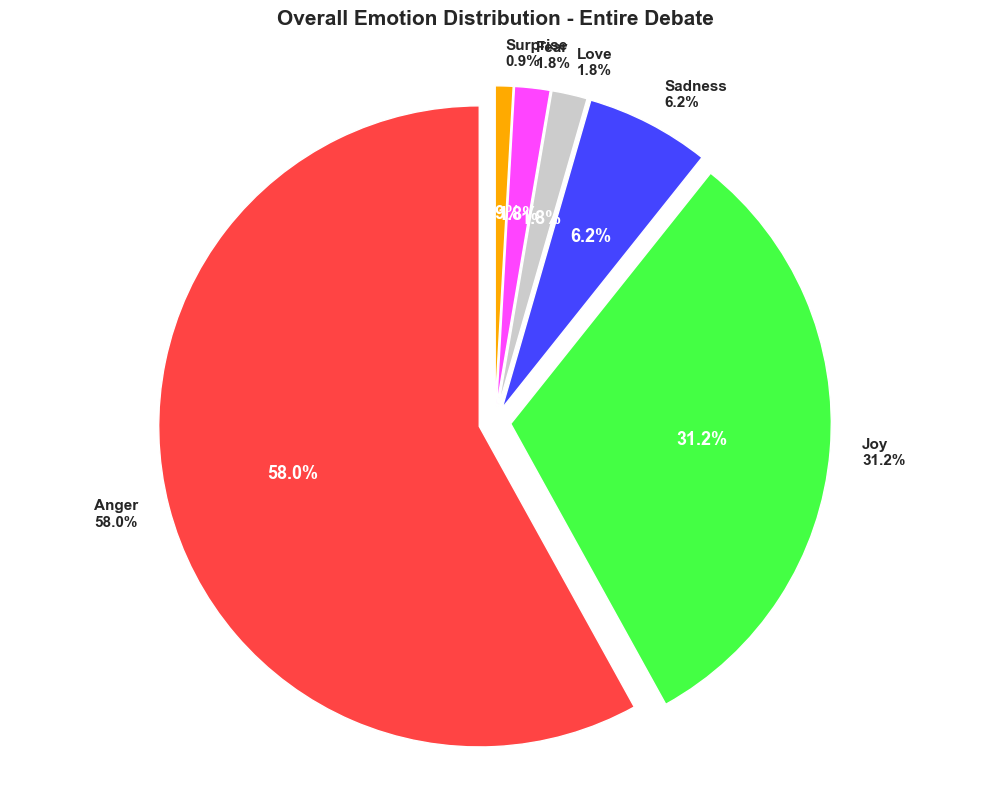

In [20]:
# ============================================================
# OVERALL EMOTION DISTRIBUTION
# ============================================================

print("=" * 70)
print("OVERALL EMOTION DISTRIBUTION")
print("=" * 70)

# Count emotions
emotion_counts = emotion_df['emotion'].value_counts()
emotion_percentages = (emotion_counts / len(emotion_df) * 100).round(1)

print("\nEmotion breakdown for entire debate:")
for emotion, count in emotion_counts.items():
    percentage = emotion_percentages[emotion]
    print(f"  {emotion.capitalize()}: {count} segments ({percentage}%)")

# ------------------------------------------------------------
# Pie chart - Overall emotion distribution
# ------------------------------------------------------------

plt.figure(figsize=(10, 8))

# Emotion colors (emoji-inspired)
emotion_colors = {
    'anger': '#ff4444',      # Red
    'joy': '#44ff44',        # Green
    'sadness': '#4444ff',    # Blue
    'fear': '#ff44ff',       # Purple
    'surprise': '#ffaa00',   # Orange
    'neutral': '#888888'     # Gray
}

colors = [emotion_colors.get(e, '#cccccc') for e in emotion_counts.index]

# Create pie chart
wedges, texts, autotexts = plt.pie(
    emotion_counts,
    labels=[f"{e.capitalize()}\n{emotion_percentages[e]}%" for e in emotion_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=[0.05] * len(emotion_counts),
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Make percentage text white
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)

plt.title('Overall Emotion Distribution - Entire Debate', 
          fontsize=15, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)

EMOTION DISTRIBUTION BY SPEAKER

SPEAKER_00 (64 segments):
  Anger: 40 (62.5%)
  Joy: 20 (31.2%)
  Sadness: 3 (4.7%)
  Love: 1 (1.6%)

SPEAKER_01 (2 segments):
  Anger: 1 (50.0%)
  Joy: 1 (50.0%)

SPEAKER_02 (46 segments):
  Anger: 24 (52.2%)
  Joy: 14 (30.4%)
  Sadness: 4 (8.7%)
  Fear: 2 (4.3%)
  Surprise: 1 (2.2%)
  Love: 1 (2.2%)

Creating emotion comparison visualization...


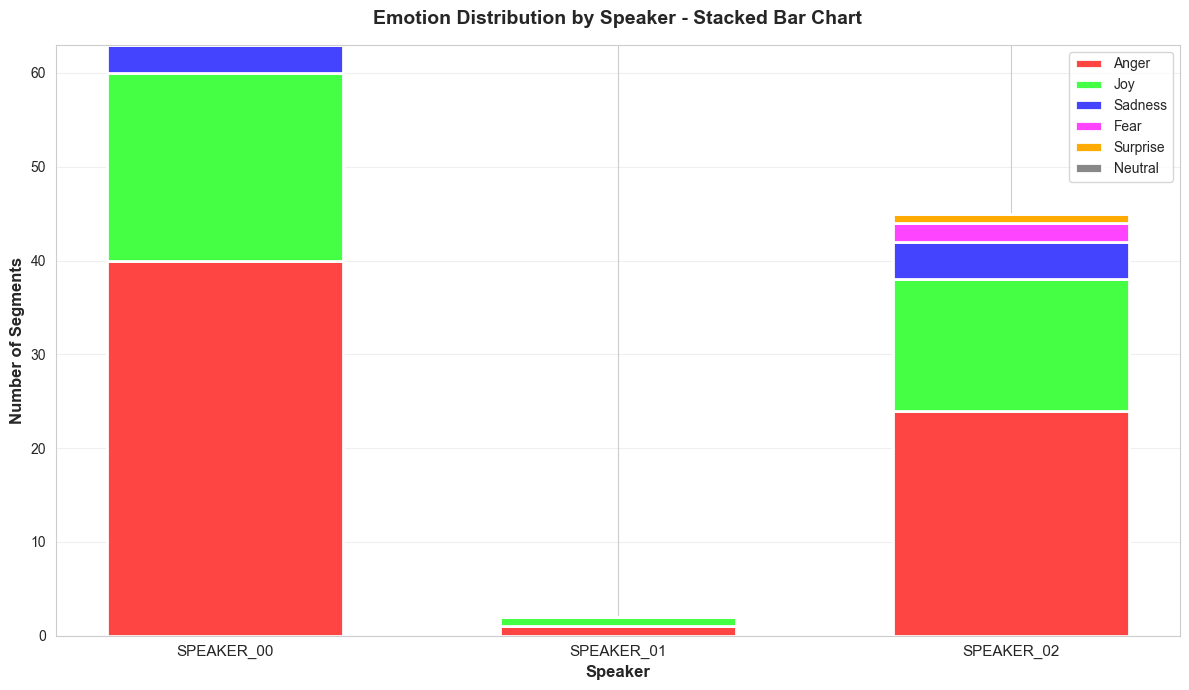

Emotion comparison visualization created!



In [21]:
# ============================================================
# EMOTION DISTRIBUTION PER SPEAKER
# ============================================================

print("=" * 70)
print("EMOTION DISTRIBUTION BY SPEAKER")
print("=" * 70)

# Get unique speakers
speakers = sorted(emotion_df['speaker'].unique())

# Calculate emotion counts per speaker
speaker_emotions = {}

for speaker in speakers:
    speaker_data = emotion_df[emotion_df['speaker'] == speaker]
    emotion_counts = speaker_data['emotion'].value_counts()
    total = len(speaker_data)
    
    speaker_emotions[speaker] = {
        'counts': emotion_counts,
        'percentages': (emotion_counts / total * 100).round(1),
        'total': total
    }
    
    print(f"\n{speaker} ({total} segments):")
    for emotion, count in emotion_counts.items():
        percentage = (count / total * 100)
        print(f"  {emotion.capitalize()}: {count} ({percentage:.1f}%)")

# ------------------------------------------------------------
# Stacked bar chart - Emotions per speaker
# ------------------------------------------------------------

print("\n" + "=" * 70)
print("Creating emotion comparison visualization...")

# Prepare data for stacked bar chart
all_emotions = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'neutral']
emotion_matrix = []

for speaker in speakers:
    speaker_data = speaker_emotions[speaker]['counts']
    row = [speaker_data.get(emotion, 0) for emotion in all_emotions]
    emotion_matrix.append(row)

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Calculate bar positions
x = np.arange(len(speakers))
width = 0.6

# Plot each emotion as a stacked bar
bottom = np.zeros(len(speakers))

for i, emotion in enumerate(all_emotions):
    values = [emotion_matrix[j][i] for j in range(len(speakers))]
    ax.bar(x, values, width, label=emotion.capitalize(), 
           bottom=bottom, color=emotion_colors.get(emotion, '#cccccc'),
           edgecolor='white', linewidth=2)
    bottom += values

# Styling
ax.set_xlabel('Speaker', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Segments', fontsize=12, fontweight='bold')
ax.set_title('Emotion Distribution by Speaker - Stacked Bar Chart', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(speakers, fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Emotion comparison visualization created!")
print("\n" + "=" * 70)

EMOTION PERCENTAGE COMPARISON


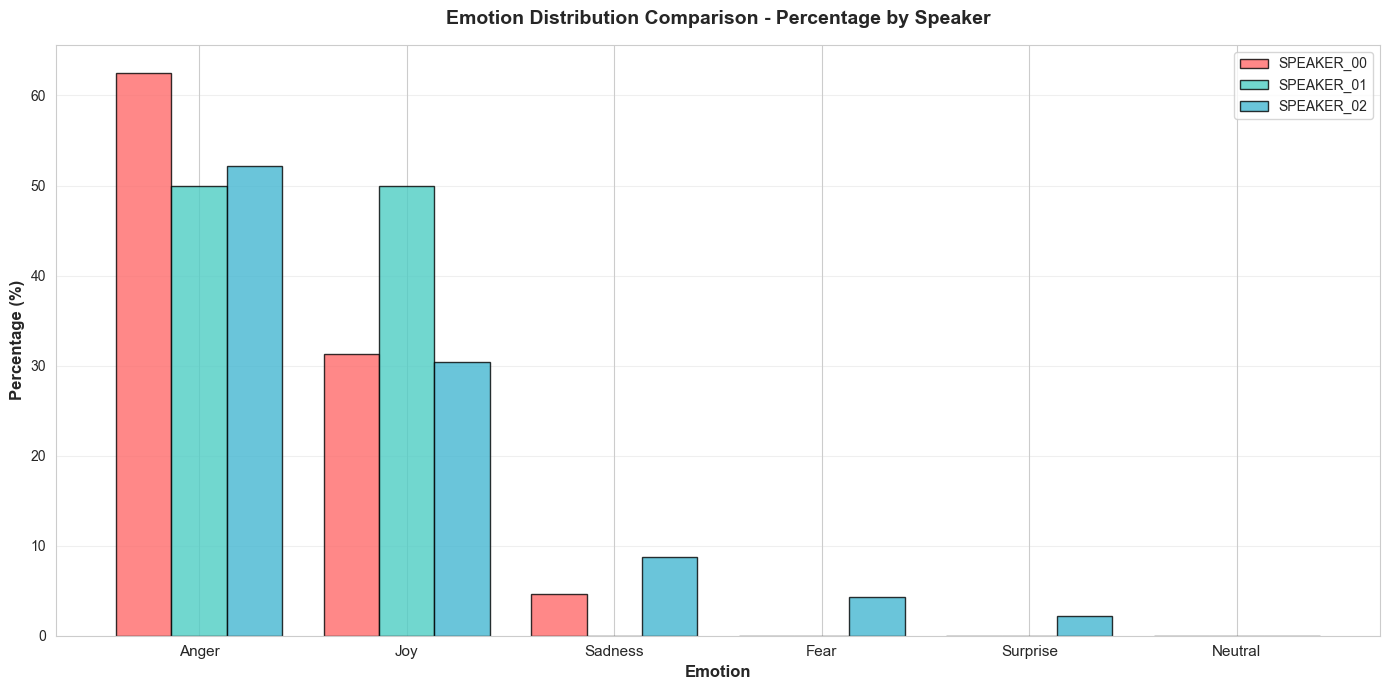

Grouped emotion comparison created!



In [22]:
# ============================================================
# GROUPED BAR CHART - EMOTION PERCENTAGES PER SPEAKER
# ============================================================

print("=" * 70)
print("EMOTION PERCENTAGE COMPARISON")
print("=" * 70)

# Prepare percentage data
percentage_matrix = []

for speaker in speakers:
    speaker_data = speaker_emotions[speaker]
    total = speaker_data['total']
    row = [(speaker_data['counts'].get(emotion, 0) / total * 100) 
           for emotion in all_emotions]
    percentage_matrix.append(row)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))

# Bar positions
x = np.arange(len(all_emotions))
width = 0.8 / len(speakers)  # Divide space by number of speakers

# Plot bars for each speaker
for i, speaker in enumerate(speakers):
    offset = width * i - (width * (len(speakers) - 1) / 2)
    values = percentage_matrix[i]
    
    ax.bar(x + offset, values, width, 
           label=speaker,
           color=speaker_colors[speaker],
           edgecolor='black',
           linewidth=1,
           alpha=0.8)

# Styling
ax.set_xlabel('Emotion', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Emotion Distribution Comparison - Percentage by Speaker', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels([e.capitalize() for e in all_emotions], fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Grouped emotion comparison created!")
print("\n" + "=" * 70)

EMOTION TIMELINE VISUALIZATION
✓ Emotion timeline created!


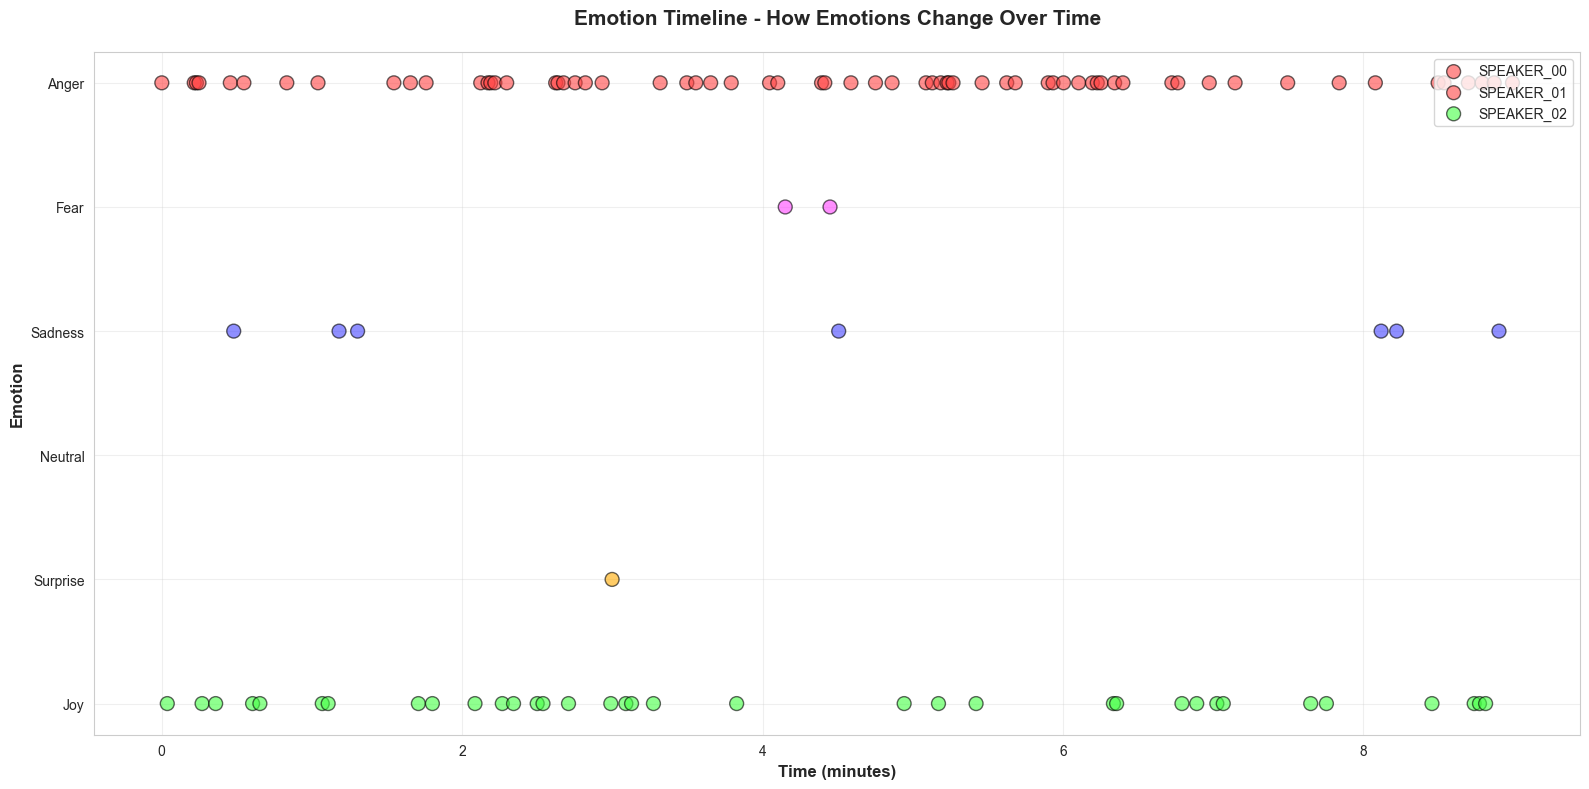

In [23]:
# ============================================================
# EMOTION TIMELINE - EMOTIONS OVER TIME
# ============================================================

print("=" * 70)
print("EMOTION TIMELINE VISUALIZATION")
print("=" * 70)

# Map emotions to numeric values for plotting
emotion_mapping = {
    'anger': 5,
    'fear': 4,
    'sadness': 3,
    'neutral': 2,
    'surprise': 1,
    'joy': 0
}

# Create timeline plot
plt.figure(figsize=(16, 8))

for speaker in speakers:
    speaker_data = emotion_df[emotion_df['speaker'] == speaker]
    
    x = speaker_data['start'] / 60  # Convert to minutes
    y = speaker_data['emotion'].map(emotion_mapping)
    
    # Scatter plot with emotion-based colors
    colors_list = [emotion_colors.get(e, '#cccccc') for e in speaker_data['emotion']]
    
    plt.scatter(x, y, 
                c=colors_list,
                label=speaker,
                s=100,
                alpha=0.6,
                edgecolors='black',
                linewidths=1)

# Styling
plt.xlabel('Time (minutes)', fontsize=12, fontweight='bold')
plt.ylabel('Emotion', fontsize=12, fontweight='bold')
plt.yticks(list(emotion_mapping.values()), 
           [e.capitalize() for e in emotion_mapping.keys()])
plt.title('Emotion Timeline - How Emotions Change Over Time', 
          fontsize=15, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3, axis='both')
plt.tight_layout()

print("✓ Emotion timeline created!")
plt.show()

print("\n" + "=" * 70)

DOMINANT EMOTION VISUALIZATION

Dominant emotion for each speaker:

SPEAKER_00:
  Dominant emotion: Anger
  Frequency: 40 segments (62.5%)

SPEAKER_01:
  Dominant emotion: Anger
  Frequency: 1 segments (50.0%)

SPEAKER_02:
  Dominant emotion: Anger
  Frequency: 24 segments (52.2%)

Creating simplified dominant emotion visualization...
Simplified dominant emotion circles created!


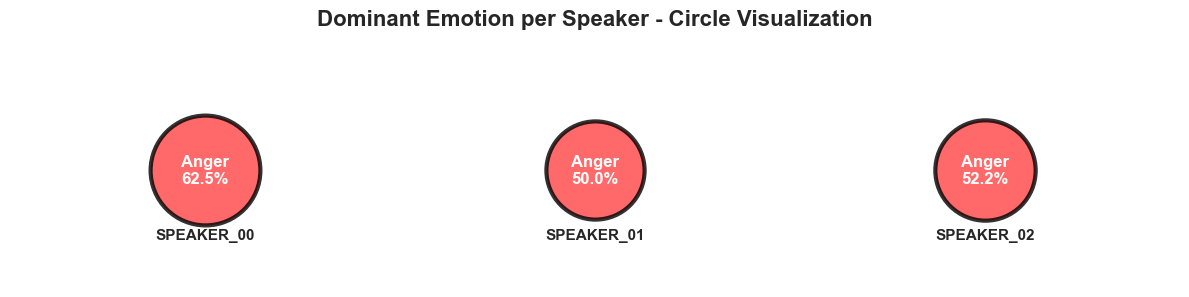


BIAS INDICATORS

SPEAKER_00:
  Negative emotions (anger/fear/sadness): 67.2%
  Positive emotions (joy): 31.2%
  → HIGH NEGATIVE EMOTION - Potential hostile environment

SPEAKER_01:
  Negative emotions (anger/fear/sadness): 50.0%
  Positive emotions (joy): 50.0%
  → HIGH NEGATIVE EMOTION - Potential hostile environment

SPEAKER_02:
  Negative emotions (anger/fear/sadness): 65.2%
  Positive emotions (joy): 30.4%
  → HIGH NEGATIVE EMOTION - Potential hostile environment



In [24]:
# ============================================================
# DOMINANT EMOTION BUBBLE CHART
# ============================================================

print("=" * 70)
print("DOMINANT EMOTION VISUALIZATION")
print("=" * 70)

# Find dominant emotion per speaker
print("\nDominant emotion for each speaker:")

dominant_data = []

for speaker in speakers:
    speaker_data = speaker_emotions[speaker]
    dominant_emotion = speaker_data['counts'].idxmax()
    dominant_count = speaker_data['counts'].max()
    dominant_percentage = speaker_data['percentages'].max()
    
    print(f"\n{speaker}:")
    print(f"  Dominant emotion: {dominant_emotion.capitalize()}")
    print(f"  Frequency: {dominant_count} segments ({dominant_percentage}%)")
    
    dominant_data.append({
        'speaker': speaker,
        'emotion': dominant_emotion,
        'count': dominant_count,
        'percentage': dominant_percentage
    })



# ------------------------------------------------------------
# Simple dominant emotion bar chart with circles
# ------------------------------------------------------------

print("\n" + "=" * 70)
print("Creating simplified dominant emotion visualization...")

fig, ax = plt.subplots(figsize=(12, 8))

# Plot only dominant emotion as large circles
for i, data in enumerate(dominant_data):
    emotion = data['emotion']
    percentage = data['percentage']
    
    # Size based on percentage
    size = percentage * 100
    
    ax.scatter(i, 0, 
              s=size,
              color=emotion_colors.get(emotion, '#cccccc'),
              alpha=0.8,
              edgecolors='black',
              linewidths=3)
    
    # Label inside circle
    ax.text(i, 0,
           f"{emotion.capitalize()}\n{percentage:.1f}%",
           ha='center', va='center',
           fontsize=12, fontweight='bold',
           color='white')
    
    # Speaker name below
    ax.text(i, -0.15,
           data['speaker'],
           ha='center', va='top',
           fontsize=11, fontweight='bold')

# Styling
ax.set_xlim(-0.5, len(dominant_data) - 0.5)
ax.set_ylim(-0.3, 0.3)
ax.set_aspect('equal')
ax.axis('off')

ax.set_title('Dominant Emotion per Speaker - Circle Visualization', 
            fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
print("Simplified dominant emotion circles created!")
plt.show()

# ------------------------------------------------------------
# Interpretation
# ------------------------------------------------------------

print("\n" + "=" * 70)
print("BIAS INDICATORS")
print("=" * 70)

for speaker in speakers:
    speaker_data = speaker_emotions[speaker]['counts']
    
    negative = (speaker_data.get('anger', 0) + 
                speaker_data.get('fear', 0) + 
                speaker_data.get('sadness', 0))
    
    positive = speaker_data.get('joy', 0)
    total = speaker_emotions[speaker]['total']
    
    negative_pct = (negative / total * 100)
    positive_pct = (positive / total * 100)
    
    print(f"\n{speaker}:")
    print(f"  Negative emotions (anger/fear/sadness): {negative_pct:.1f}%")
    print(f"  Positive emotions (joy): {positive_pct:.1f}%")
    
    if negative_pct > 40:
        print(f"  → HIGH NEGATIVE EMOTION - Potential hostile environment")
    elif positive_pct > 30:
        print(f"  → High positive emotion - Friendly/supportive interaction")
    else:
        print(f"  → Balanced emotional tone")

print("\n" + "=" * 70)

## Topic Extraction with KeyBERT

In this section, we extract the main topics and keywords from the transcript using the KeyBERT model.  
KeyBERT leverages powerful transformer embeddings to find the most relevant phrases that summarize what was discussed, either for the whole debate, per speaker, or per segment.

- **Why?**  
  Topic extraction helps quickly identify the main themes, arguments, and focus areas in the conversation.

- **How?**  
  We will use KeyBERT to extract keywords from the transcript, and optionally break them down by speaker or by time segment.

---

In [26]:
# Install KeyBERT and dependencies (run once)
!pip install keybert sentence-transformers

# Import KeyBERT
from keybert import KeyBERT

# Load the model (this can take a few seconds)
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

print("KeyBERT model loaded and ready!")

   ---------------------------------------- 0.0/41.4 kB ? eta -:--:--
   --------- ------------------------------ 10.2/41.4 kB ? eta -:--:--
   ----------------------------- ---------- 30.7/41.4 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 41.4/41.4 kB 399.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/488.0 kB ? eta -:--:--
   --- ------------------------------------ 41.0/488.0 kB 1.9 MB/s eta 0:00:01
   ----- --------------------------------- 71.7/488.0 kB 787.7 kB/s eta 0:00:01
   ----------- ---------------------------- 143.4/488.0 kB 1.1 MB/s eta 0:00:01
   -------------------- ------------------- 256.0/488.0 kB 1.6 MB/s eta 0:00:01
   -------------------------- ------------- 317.4/488.0 kB 1.5 MB/s eta 0:00:01
   ------------------------------ --------- 368.6/488.0 kB 1.5 MB/s eta 0:00:01
   ------------------------------ --------- 368.6/488.0 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------  481.3/488.0 kB 1.4 MB/s e


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


KeyBERT model loaded and ready!


In [31]:
# First Clean the Audio Transcript Text
def clean_text(text):
    text = text.lower()
    # Remove common filler words (handles word boundaries and punctuation)
    filler_words = ["um", "uh", "like", "you know", "yeah", "ok", "right", "oh"]
    import re
    for fw in filler_words:
        # Remove filler words surrounded by word boundaries (handles punctuation)
        text = re.sub(rf'\b{re.escape(fw)}\b', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Combine all text into one long string
full_text = " ".join([segment.get('text', '').strip() for segment in result['segments']])

# Clean it
full_text = clean_text(full_text)

print(full_text[:500])

she doesn't have a plan. she copied biden's plan and it's four sentences, run spot run, four sentences that are just, , we'll try and lower taxes. she doesn't have a plan. take a look at her plan. she doesn't have a plan. i believe in the ambition, the aspirations, the dreams of the american people. and that is why i imagine and have actually a plan to build what i call an opportunity economy. because here's the thing. we know that we have a shortage of homes in housing. and the cost of housing 


In [ ]:
# Extract Key Topics - Simply
topics = kw_model.extract_keywords(
    full_text,
    top_n=10,
    use_mmr=True,
    diversity=0.6
)

topics


[('tariffs', 0.3304),
 ('biden', 0.3219),
 ('intend', 0.262),
 ('autocrats', 0.2318),
 ('immoral', 0.1314),
 ('agree', 0.1225),
 ('pipeline', 0.1088),
 ('pregnancy', 0.0716),
 ('probably', 0.0692),
 ('divide', 0.0518)]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Enhanced Topic Extraction with Custom Vectorizer
# (Assumes kw_model and full_text are already defined and full_text is cleaned)

vectorizer = CountVectorizer(
    ngram_range=(1, 3),        # 1 to 3-word phrases
    stop_words='english',
    min_df=2                   # remove extremely rare words
)

topics = kw_model.extract_keywords(
    full_text,
    vectorizer=vectorizer,
    use_mmr=True,
    diversity=0.6,
    top_n=10
)

# Display topics in a readable format
print("=" * 70)
print("ENHANCED TOPIC EXTRACTION (Top 10 Key Phrases)")
print("=" * 70)
for idx, (phrase, score) in enumerate(topics, 1):
    print(f"{idx:2d}. {phrase}  (score: {score:.3f})")
print("=" * 70)

ValueError: max_df corresponds to < documents than min_df